<center>
    <img width="300px" src="https://img.freepik.com/premium-vector/pink-ribbon-breast-cancer-awareness-grunge-style-vector-design-breast-cancer-awareness-month_690789-121.jpg"/>

# Breast Cancer Detection using LightGBM
</center>
In this notebook I will demonstrate how to use lightGBM to run the binary classification task to predict breast cancer.

## About the Dataset
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. 
n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: 
ftp ftp.cs.wisc.edu 
cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 
2) Diagnosis (M = malignant, B = benign) 
3-32)

Ten real-valued features are computed for each cell nucleus:

    a) radius (mean of distances from center to points on the perimeter) 
    b) texture (standard deviation of gray-scale values) 
    c) perimeter 
    d) area 
    e) smoothness (local variation in radius lengths) 
    f) compactness (perimeter^2 / area - 1.0) 
    g) concavity (severity of concave portions of the contour) 
    h) concave points (number of concave portions of the contour) 
    i) symmetry 
    j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid", color_codes=True, font_scale=1.3)

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

Let´s load the data into a Pandas DataFrame and to get a general overview.

In [100]:
data = pd.read_csv('breast_cancer_classification_dataset.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
data.shape

(569, 33)

We have 569 observations and 33 columns. We are not interested in column `id`. The last column `Unnamed: 32` contains NaN. So let´s drop them immediately. 

In [5]:
data = data.drop(columns=['id', 'Unnamed: 32'])

Lets get some general information about the DataFrame.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

It looks like our data does not contain any missing values. Good for us, we can skip the "missing value handling" part. 
Our target variable `diagnosis`, is categorical and has two classes. 'B' (Benign) and 'M' (Malignant'). All explainatory features are numerical, so we can also skip the data type conversion. 

## Exploratory Data Analysis
The first step in the EDA is to get some statistical insights about the data

In [7]:
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


First we have a closer look on our target, since it is the main focus of our analysis. We begin by checking the distribution of its classes. 

No. Benign:  357
No. Malignant :  212

% of cells labeled Benign 62.74 %
% of cells labeled Malignant 37.26 %


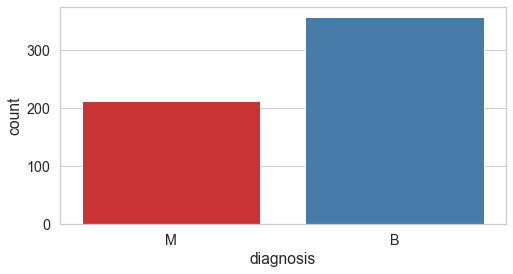

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(data['diagnosis'], palette='Set1')

# Count number of observations in each class
benign, malignant = data['diagnosis'].value_counts()
print('No. Benign: ', benign)
print('No. Malignant : ', malignant)
print('')
print('% of cells labeled Benign', round(benign / len(data) * 100, 2), '%')
print('% of cells labeled Malignant', round(malignant / len(data) * 100, 2), '%')

Out of the 569 observations, 357 (62,75%) are labeled benign. So we have kind of a balanced dataset. No need to apply some imbalanced dataset techniques like SMOTE. 

Lets take a look at the correlations between our variables. 

Although our dataset has 30 columns excluding the `id` and `diagnosis` columns, they are all in fact very closely related since they all contain information on the same 10 key attributes but differ in terms of their perspectives (the mean, the standard errors and mean of the three largest values). Lets plot a pairplot of all `radius` related columns. 

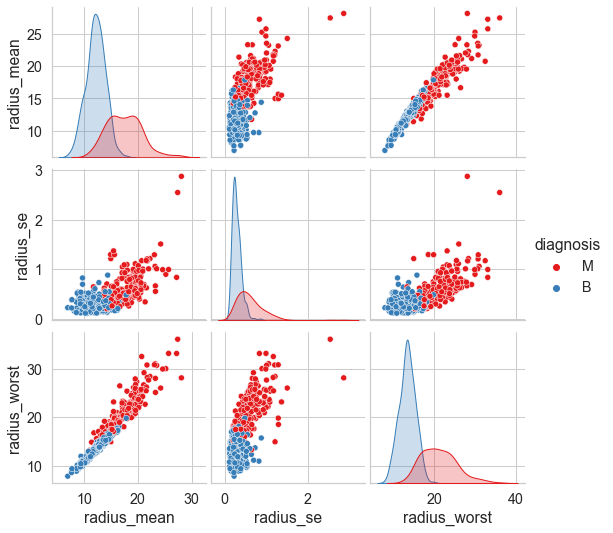

In [11]:
rad_cols = ['diagnosis', 'radius_mean', 'radius_se', 'radius_worst']
sns.pairplot(data=data[rad_cols], hue='diagnosis', palette='Set1')

Lets try another triple, lets say `smoothness`. Are the results different?

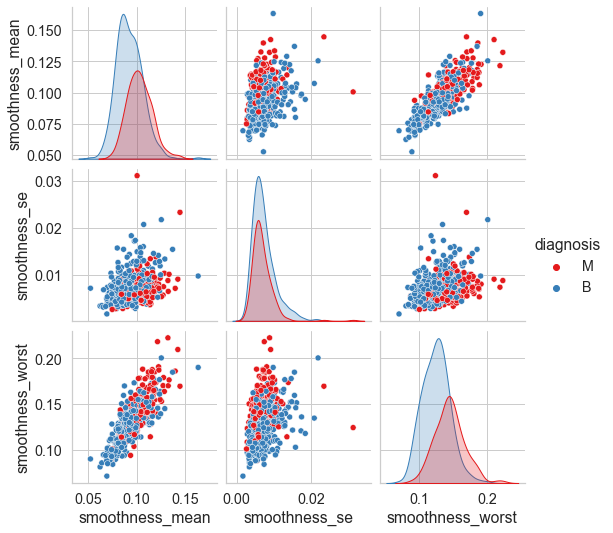

In [13]:
smooth_cols = ['diagnosis', 'smoothness_mean', 'smoothness_se', 'smoothness_worst']
sns.pairplot(data=data[smooth_cols], hue='diagnosis', palette='Set1')

And one last plot for the `texture` columns.

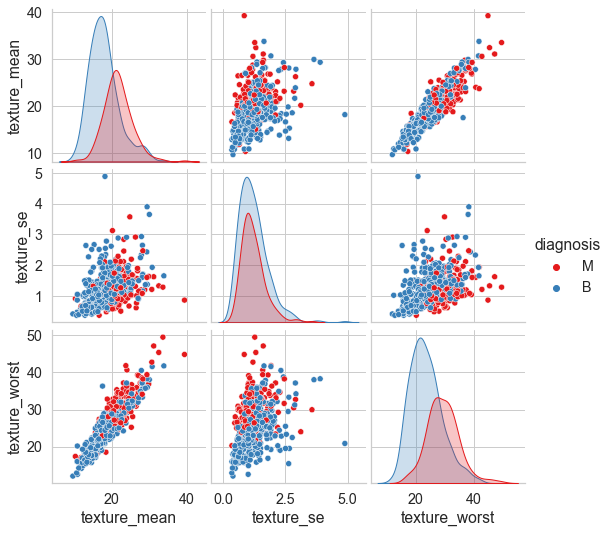

In [14]:
texture_cols = ['diagnosis', 'texture_mean', 'texture_se', 'texture_worst']
sns.pairplot(data=data[texture_cols], hue='diagnosis', palette='Set1')

There is almost a perfect linear pattern between `radius_mean` and `radius_worst` which are hinting at the presence of multicollinearity between these variables. For the attributes `smoothness_mean` and `smoothness_worst` as well as for `texture_mean` and `texture_worst`. 

Let´s quickly create a pairplot between the mean columns and our target. 

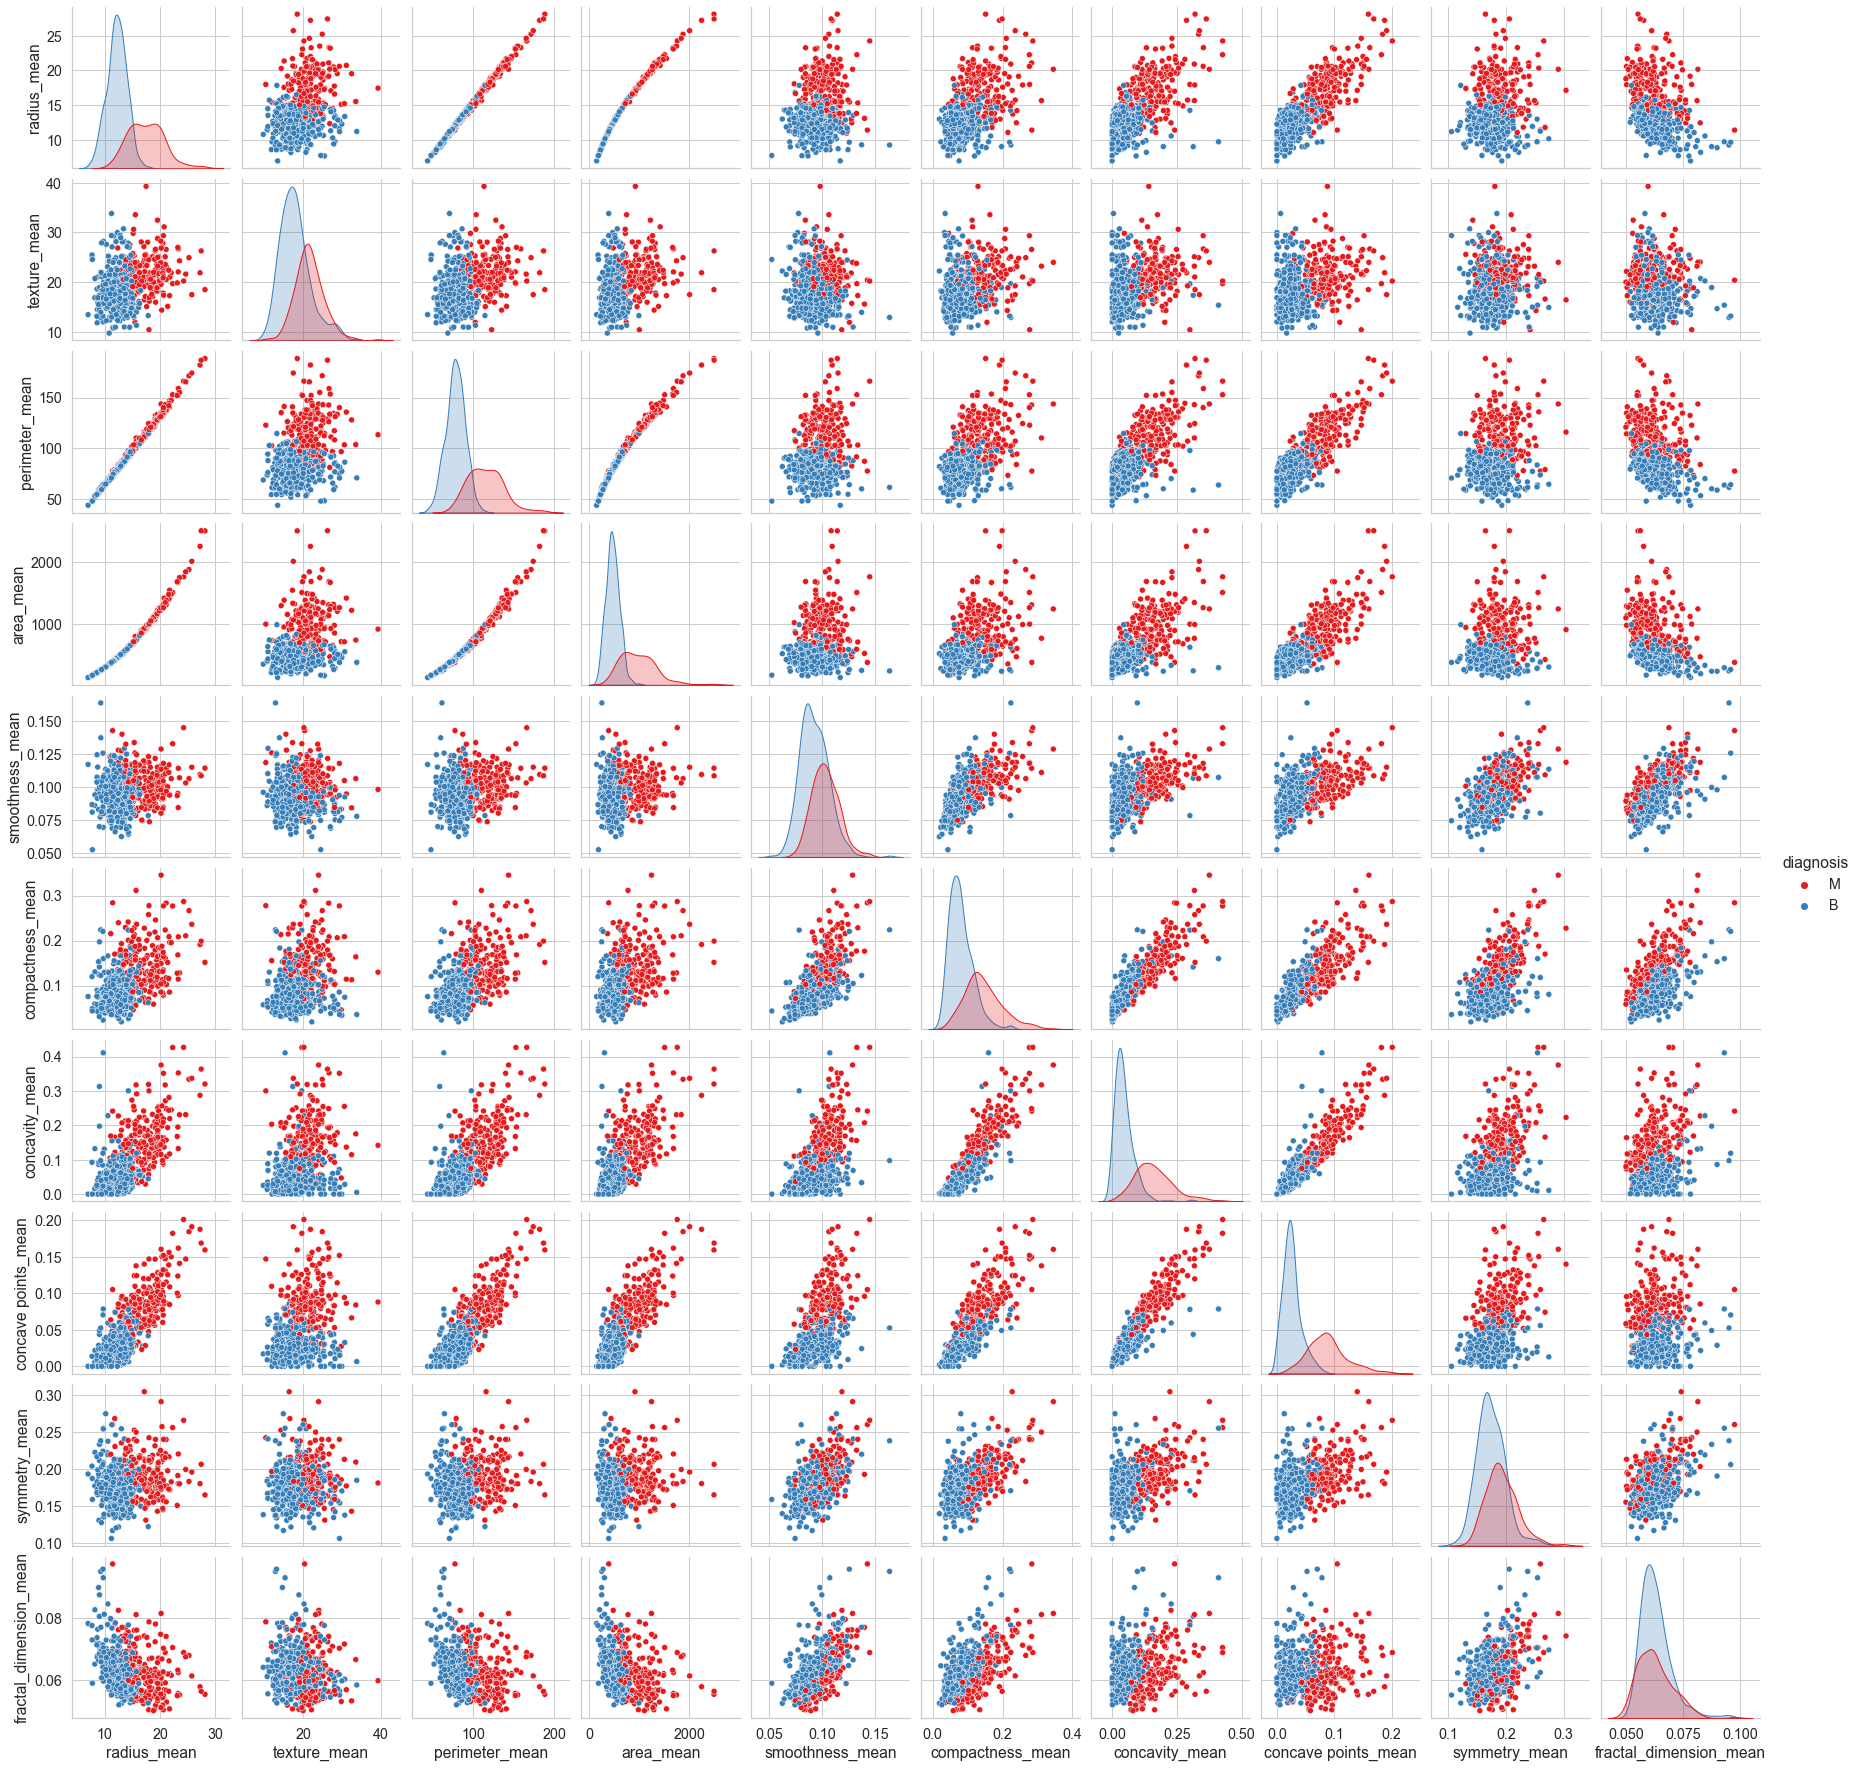

In [15]:
cols = ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 
        'compactness_mean', 'concavity_mean','concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
sns.pairplot(data=data[cols], hue='diagnosis', palette='Set1')

I see another interesting pattern between `radius_mean` and `area_mean` and `perimeter_mean`. This is understandable because they basically share the same information. Lets check the corrleations between our variables. 

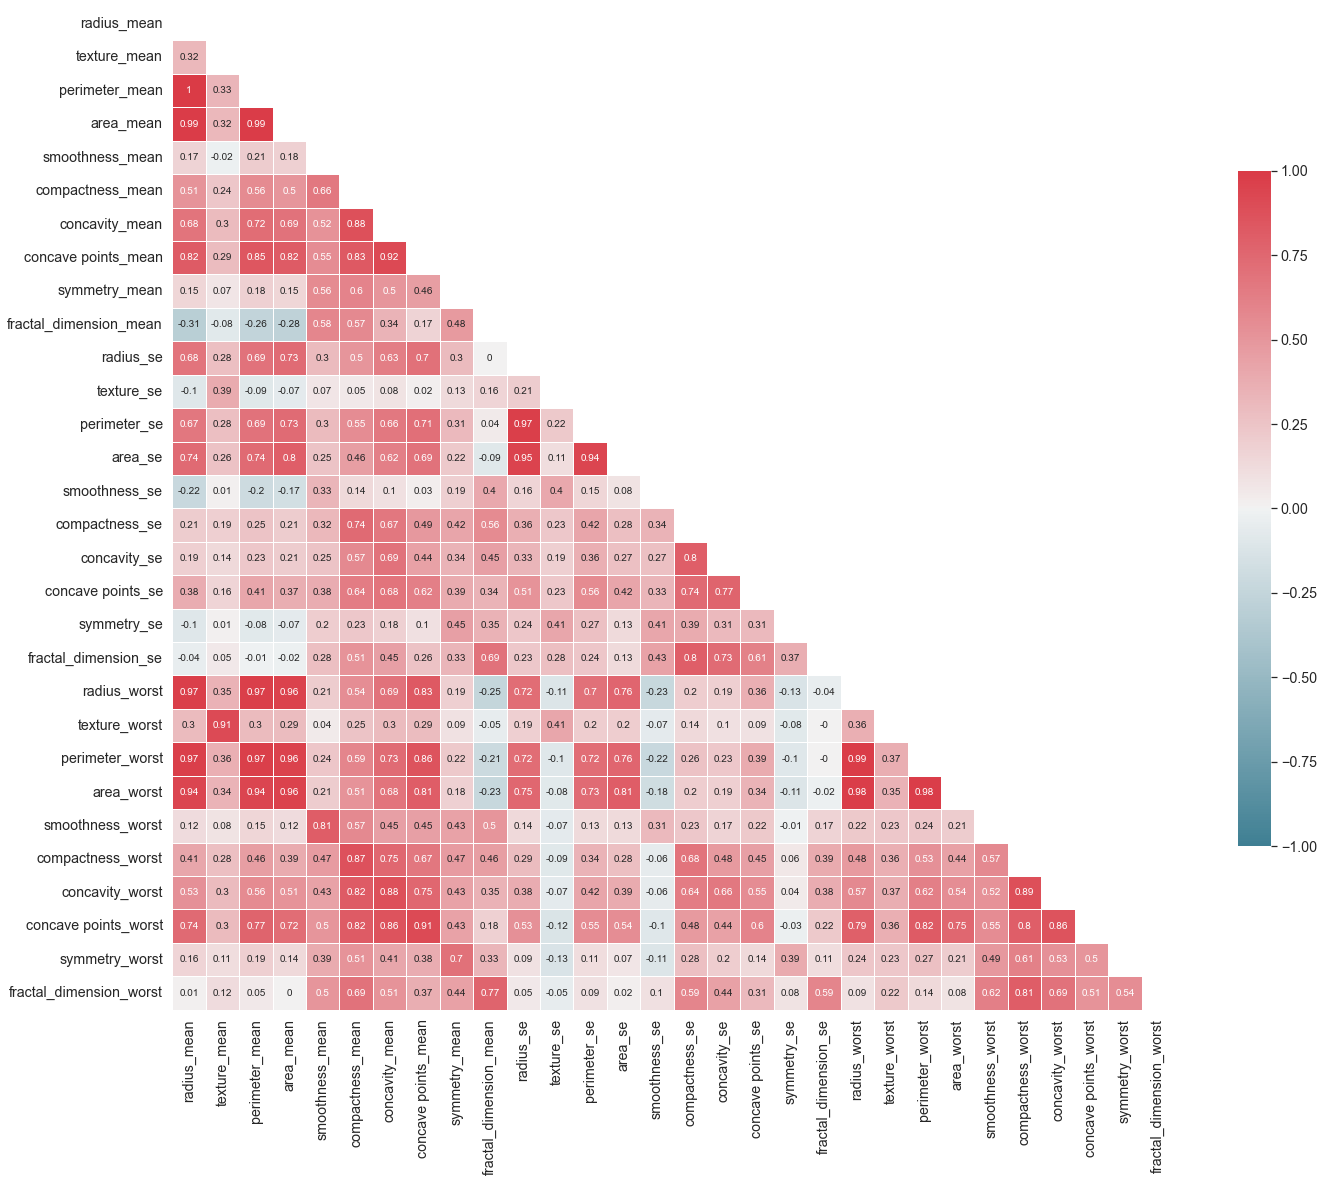

In [18]:
corr = data.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

A lot of dark red squares. There are some variables with high correlation to each other, we have to drop one of them. I am lazy to drop them one by one, instead I create another correlation matrix with `abs()` values. I will find featues with correlation greater than 0.9 and drop them.

In [21]:
df = data.copy()
corr_mat = df.corr().abs()
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
df.drop(to_drop, axis=1, inplace=True)

Let´s plot the correlation matrix again to check if everything is fine. 

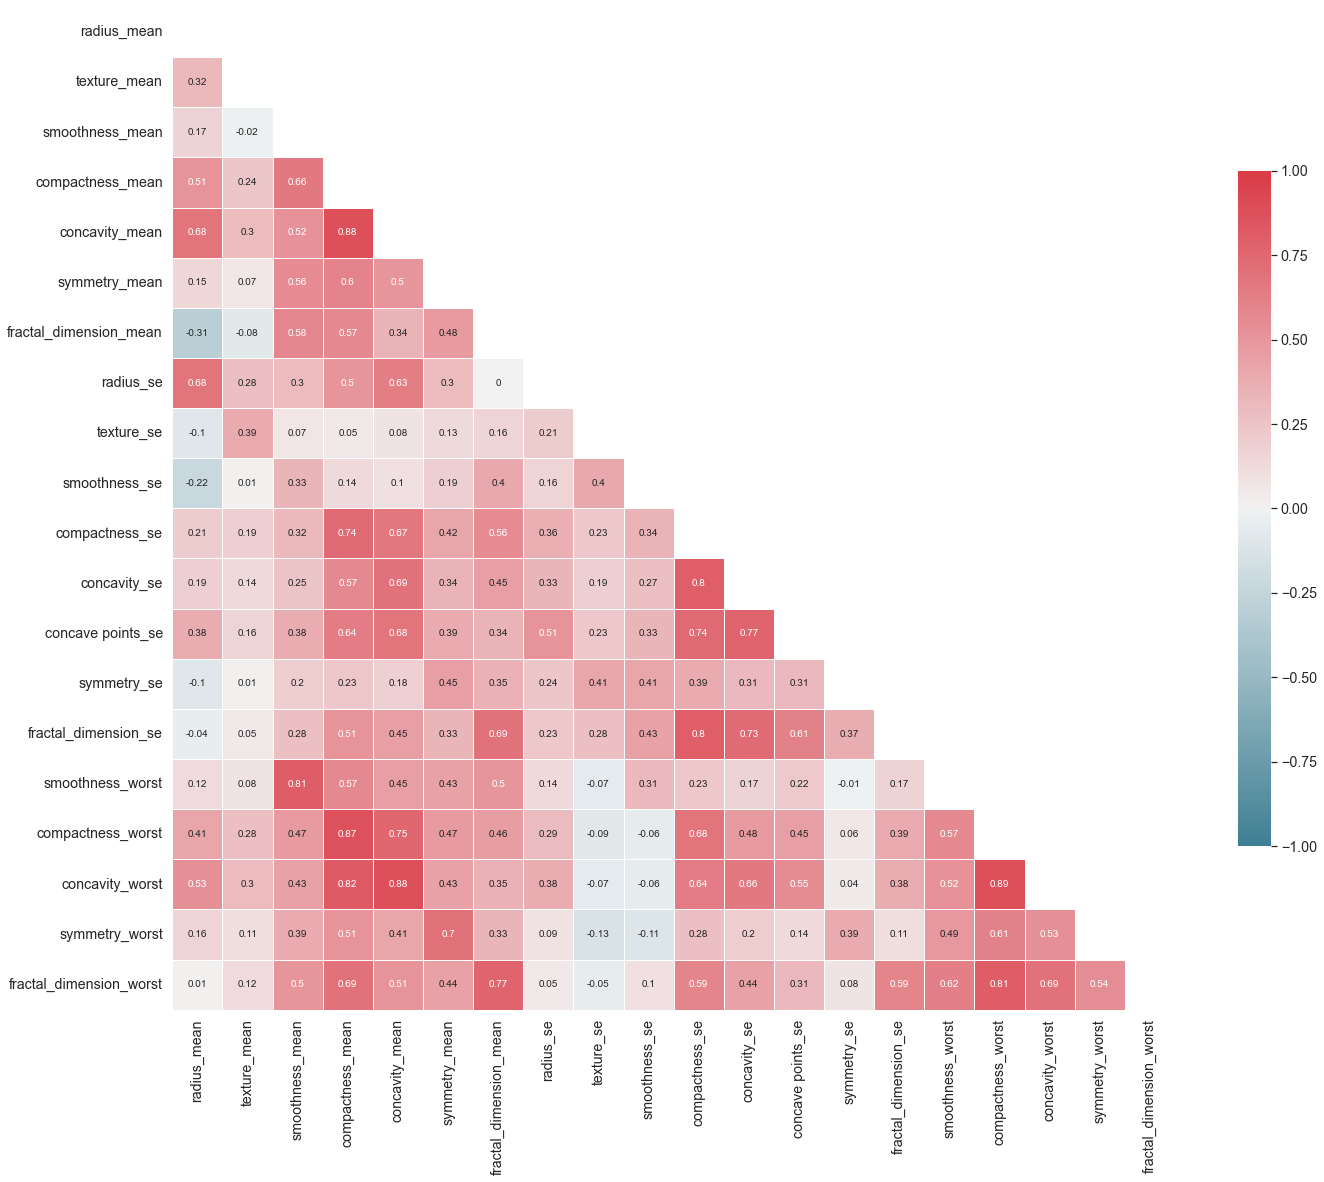

In [23]:
corr = df.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

In [27]:
print(f'Old Shape: {data.shape}')
print(f'New Shape: {df.shape}')

Old Shape: (569, 31)
New Shape: (569, 21)


So far so good, we dropped 10 columns. Anything else we can check? Let´s create some violin plots. 
First we have to normalize the features, to bring them into the same scale. 
For better readability I will create two groups with 10 and 11 features. 

In [ ]:
def violin_plot(beginning,end):
    data = pd.concat([y,X_norm.iloc[:,beginning:end]],axis=1)
    data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name='value')
    plt.figure(figsize=(10,10))
    sns.violinplot(x="features", y="value", hue="diagnosis", data=data, split=True, inner="quart", palette='Set1')
    plt.xticks(rotation=45)

In [ ]:
y = df['diagnosis']
X = df.drop(columns=['diagnosis'])
X_norm = (X - X.mean()) / X.std()

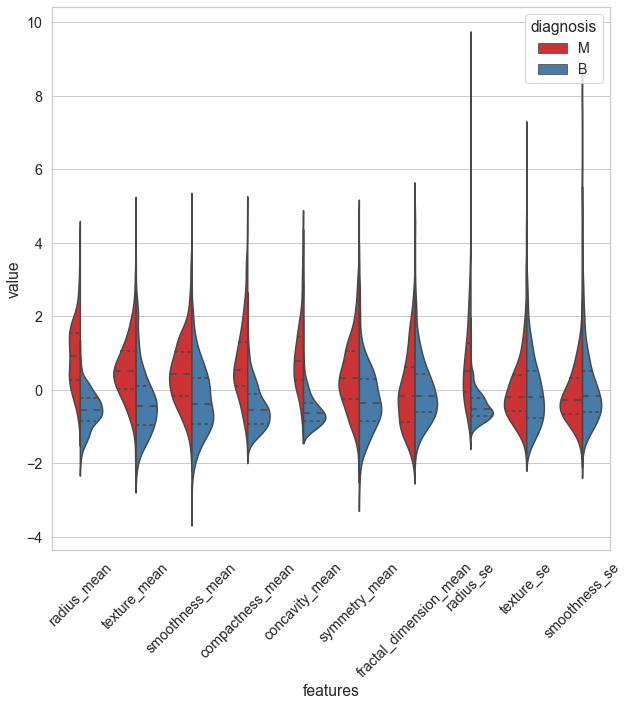

In [ ]:
violin_plot(0,10)

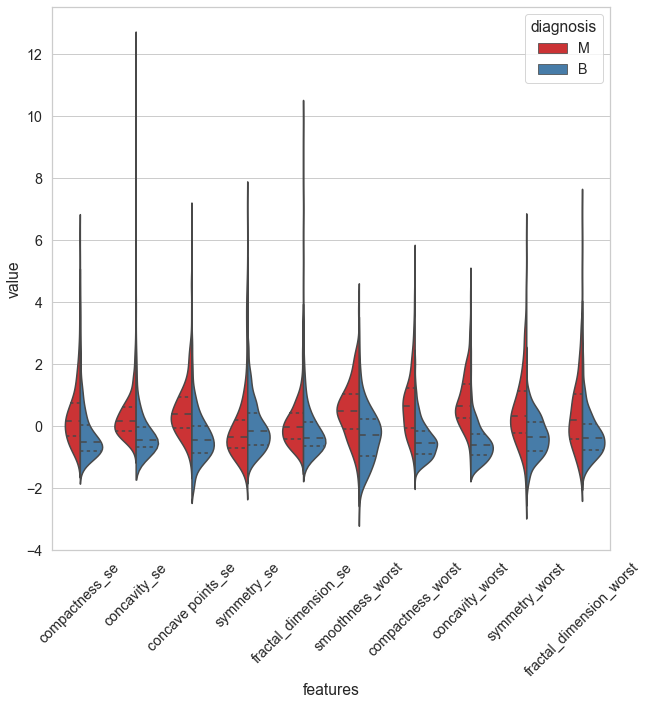

In [ ]:
violin_plot(10,21)

Lets interpret the plots. Red means Malignant' and blue means 'Benign'. For example for `radius_mean`, `texture_mean`, `convacity_mean`and `convacity_worst` looks like separated so it can be good for classification. However, for `fractal_dimension_mean`, `texture_se` and `smoothness_se` the median of the Malignant and Benign does not look separated, so it goes not give good inforamtion for classification. Should we remove them?
Let´s create another plot. A swarm plot would be a good choice.

In [55]:
def swarm_plot(beginning,end):
    data = pd.concat([y,X_norm.iloc[:,beginning:end]],axis=1)
    data = pd.melt(data, id_vars="diagnosis", var_name="features", value_name='value')
    plt.figure(figsize=(20,20))
    sns.swarmplot(x="features", y="value", hue="diagnosis", data=data, palette='Set1')
    plt.xticks(rotation=90)

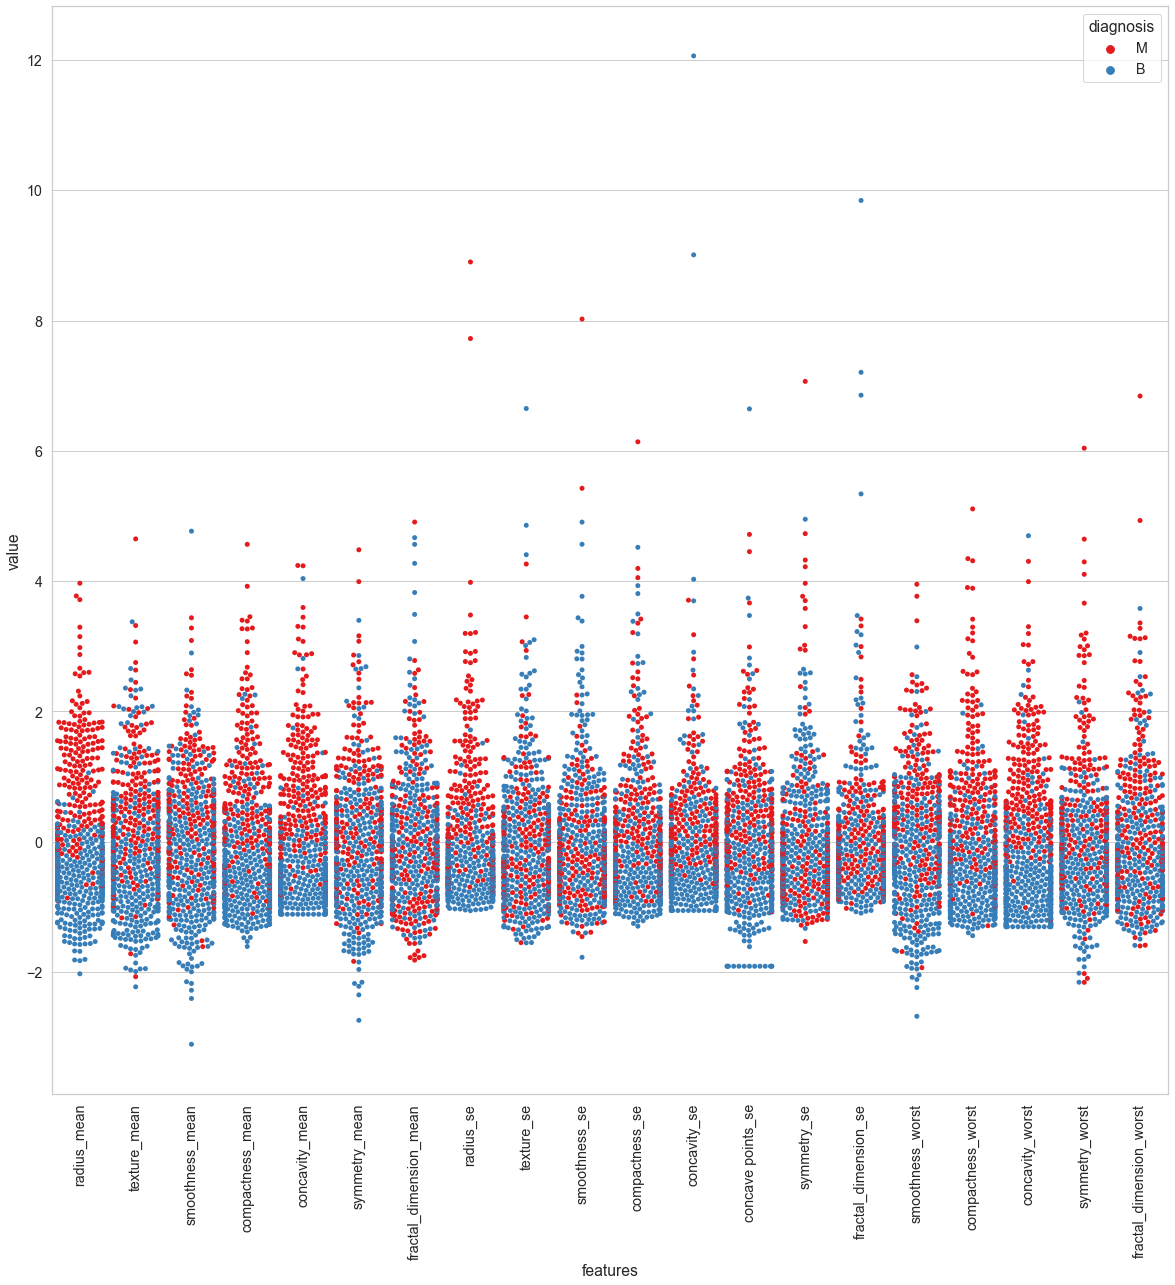

In [56]:
swarm_plot(0, 21)

So how to interpret the plots. Each dot represents a cancer patient, red indicates Malignant and blue Benign patients. Swarm plot is a good tool to see variance more clear. So which feature are mixed?
After using the insights of the violin plots and swarm plots together I choose following columns to drop:
- fractal_dimension_mean
- texture_se
- smoothness_se
- symmetry_worst
- smoothness_worst

In [57]:
df = df.drop(columns=['fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_worst', 'smoothness_worst'])

In [58]:
df.shape

(569, 16)

Enough for now. The final dataset for modeling has 569 observations and 15 features. 
Without further do, lets train a lightGBM model. 

## Modeling


In [60]:
X = df.drop(columns=['diagnosis'])
y = df.diagnosis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=1702)

In [61]:
# Create lightGBM Classifier and train model
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [63]:
# Run prediction
y_pred = clf.predict(X_test)

In [65]:
accuracy_score(y_test, y_pred)

0.9473684210526315

So the results are pretty good. We reach an accuracy score near 95%

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.93      1.00      0.96        38
           M       1.00      0.84      0.91        19

    accuracy                           0.95        57
   macro avg       0.96      0.92      0.94        57
weighted avg       0.95      0.95      0.95        57



In [69]:
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

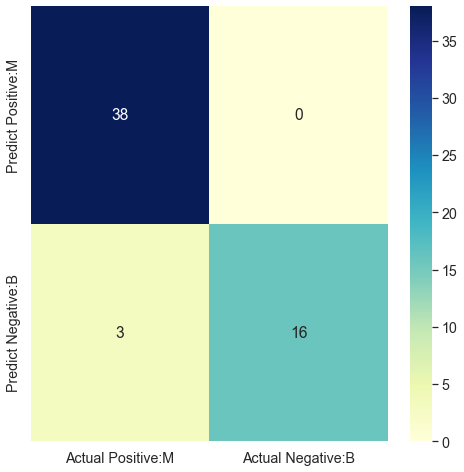

In [77]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:M', 'Actual Negative:B'], 
                                 index=['Predict Positive:M', 'Predict Negative:B'])
plt.figure(figsize=(8,8))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu')

The confusion matrix looks quite good. However 3 patients where classified Benign although they are actual Malignant. For you as a patient this is a devastating error. Can we do any better?
Lets run hyperparameter optimization with random grid search. 

In [87]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': np.arange(100, 1000, 100),
    'learning_rate': np.logspace(-3, 0, num=100),
    'max_depth': [3, 5, 7, 9],
    'num_leaves': np.arange(10, 100, 10)
}

clf = lgb.LGBMClassifier()
# Perform random search with cross-validation
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=100, cv=3, scoring='accuracy')
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

In [88]:
best_model

LGBMClassifier(learning_rate=0.21544346900318845, max_depth=5, n_estimators=500,
               num_leaves=50)

In [89]:
preds_opt_model = best_model.predict(X_test)

In [90]:
accuracy_score(y_test, preds_opt_model)

0.9649122807017544

In [92]:
print(classification_report(y_test, preds_opt_model))

              precision    recall  f1-score   support

           B       0.95      1.00      0.97        38
           M       1.00      0.89      0.94        19

    accuracy                           0.96        57
   macro avg       0.97      0.95      0.96        57
weighted avg       0.97      0.96      0.96        57



In [95]:
cm = confusion_matrix(y_test, preds_opt_model)

<AxesSubplot:>

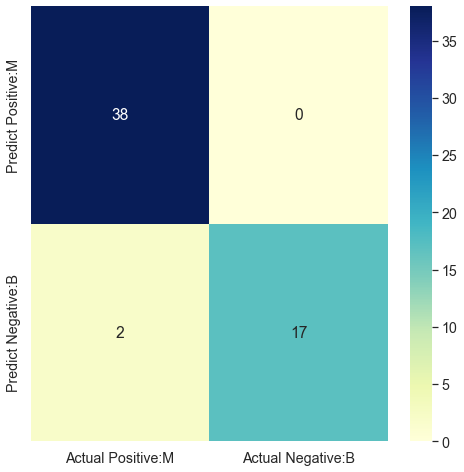

In [96]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:M', 'Actual Negative:B'], 
                                 index=['Predict Positive:M', 'Predict Negative:B'])
plt.figure(figsize=(8,8))
sns.heatmap(cm_matrix, annot=True, cmap='YlGnBu')

Finally plot the feature importance from our best estimator. 

<AxesSubplot:xlabel='Value', ylabel='Feature'>

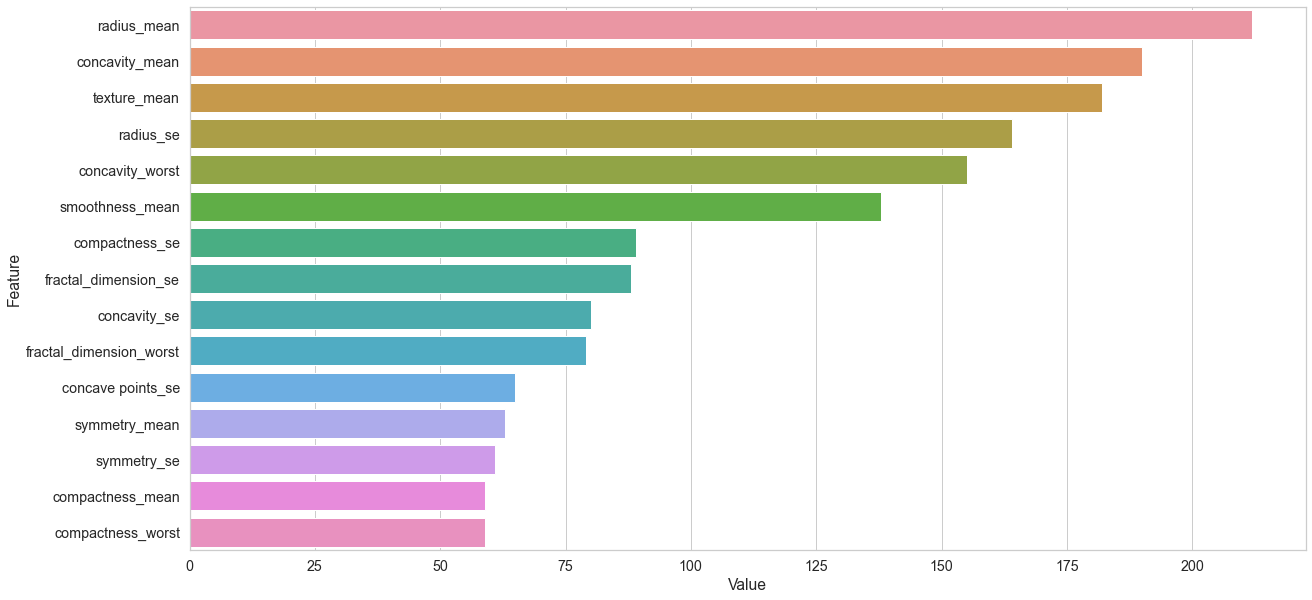

In [97]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))

So now we missclassified only 2 people, still not good for medical perspective but I guess this notebook gives you a good overview how to apply a lightGBM Classifier to solve a binary classification task.